# 문서 군집화
---
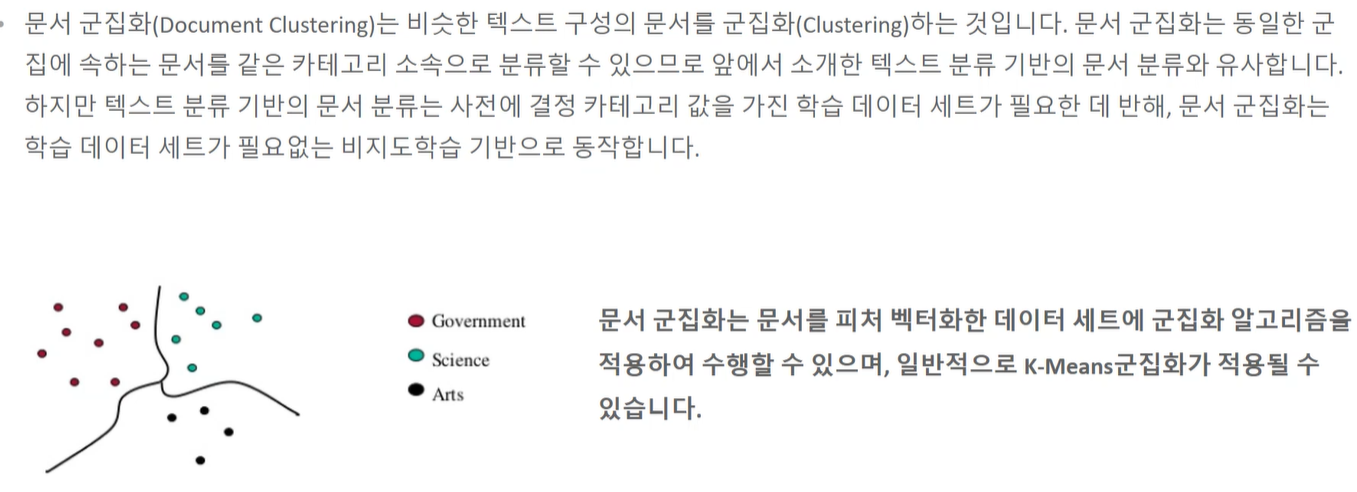

**데이터 로딩**

In [1]:
import pandas as pd
import glob ,os

# 아래는 제 컴퓨터에서 압축 파일을 풀어 놓은 디렉토리이니, 여러분의 디렉토리를 설정해 주십시요  
path = r'C:\Users\67416\머신러닝인강\data\topics'                     
# path로 지정한 디렉토리 밑에 있는 모든 .data 파일들의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

# 개별 파일들의 파일명은 filename_list 리스트로 취합, 
# 개별 파일들의 파일내용은 DataFrame로딩 후 다시 string으로 변환하여 opinion_text 리스트로 취합 
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성 
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    
    # 절대경로로 주어진 file 명을 가공. 만일 Linux에서 수행시에는 아래 \\를 / 변경. 맨 마지막 .data 확장자도 제거
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]

    #파일명 리스트와 파일내용 리스트에 파일명과 파일 내용을 추가. 
    filename_list.append(filename)
    opinion_text.append(df.to_string())

# 파일명 리스트와 파일내용 리스트를  DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()


C:\Users\67416\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  from ipykernel import kernelapp as app


,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc..."
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and..."
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...
3,battery-life_ipod_nano_8gb,short battery life I moved up from a...
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2..."


**Lemmatization을 위한 함수 생성**

In [2]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

**TF-IDF 피처 벡터화, TffidVectorizer에서 피처 벡터화 수행 시 Lemmatization을 적용하여 토큰화**

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])


C:\Users\67416\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


**5개의 군집으로 K-Means군집화**

In [4]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=0 
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

**군집화된 그룹별로 데이터 확인**

In [5]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc...",3
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and...",0
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...,4
3,battery-life_ipod_nano_8gb,short battery life I moved up from a...,4
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2...",4


In [6]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
1,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and...",0
32,room_holiday_inn_london,"We arrived at 23,30 hours and they could n...",0
30,rooms_bestwestern_hotel_sfo,"Great Location , Nice Rooms , Helpless...",0
31,rooms_swissotel_chicago,The Swissotel is one of our favorite hotel...,0


In [7]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
13,food_holiday_inn_london,The room was packed to capacity with queu...,1
14,food_swissotel_chicago,The food for our event was deli...,1
15,free_bestwestern_hotel_sfo,The wine reception is a great idea as it i...,1
20,location_bestwestern_hotel_sfo,"Good Value good location , ideal ...",1
21,location_holiday_inn_london,Great location for tube and we crammed in...,1
24,parking_bestwestern_hotel_sfo,Parking was expensive but I think this is ...,1
28,price_holiday_inn_london,"All in all, a normal chain hotel on a nice...",1
38,service_bestwestern_hotel_sfo,Both of us having worked in tourism for o...,1
39,service_holiday_inn_london,"not customer, oriented hotelvery low servi...",1
40,service_swissotel_hotel_chicago,Mediocre room and service for a very extr...,1


In [8]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
6,comfort_honda_accord_2008,"Drivers seat not comfortable, the car its...",2
7,comfort_toyota_camry_2007,Ride seems comfortable and gas mileage fa...,2
16,gas_mileage_toyota_camry_2007,Ride seems comfortable and gas mileage fa...,2
17,interior_honda_accord_2008,I love the new body style and the interior...,2
18,interior_toyota_camry_2007,"First of all, the interior has way too ma...",2
22,mileage_honda_accord_2008,"It's quiet, get good gas mileage and look...",2
25,performance_honda_accord_2008,"Very happy with my 08 Accord, performance i...",2
29,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which ...,2
37,seats_honda_accord_2008,Front seats are very uncomfor...,2
47,transmission_toyota_camry_2007,"After slowing down, transmission has to b...",2


In [9]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc...",3
5,buttons_amazon_kindle,I thought it would be fitting to christen ...,3
8,directions_garmin_nuvi_255W_gps,You also get upscale features like spoken ...,3
9,display_garmin_nuvi_255W_gps,3 quot widescreen display was a ...,3
10,eyesight-issues_amazon_kindle,It feels as easy to read as the K1 but doe...,3
12,fonts_amazon_kindle,Being able to change the font sizes is aw...,3
23,navigation_amazon_kindle,"In fact, the entire navigation structure h...",3
27,price_amazon_kindle,"If a case was included, as with the Kindle...",3
33,satellite_garmin_nuvi_255W_gps,It's fast to acquire satel...,3
43,speed_garmin_nuvi_255W_gps,Another feature on the 255w is a display of...,3


In [10]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
2,battery-life_amazon_kindle,After I plugged it in to my USB hub on my ...,4
3,battery-life_ipod_nano_8gb,short battery life I moved up from a...,4
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 2...",4
11,features_windows7,"I had to uninstall anti, virus and selecte...",4
19,keyboard_netbook_1005ha,", I think the new keyboard rivals the gre...",4
26,performance_netbook_1005ha,The Eee Super Hybrid Engine utility lets u...,4
34,screen_garmin_nuvi_255W_gps,It is easy to read and when touching the...,4
35,screen_ipod_nano_8gb,"As always, the video screen is sharp and b...",4
36,screen_netbook_1005ha,Keep in mind that once you get in a room ...,4
41,size_asus_netbook_1005ha,A few other things I'd like to point out i...,4


In [11]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_


# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very acc...",0
48,updates_garmin_nuvi_255W_gps,Another thing to consider was that I paid $...,0
47,transmission_toyota_camry_2007,"After slowing down, transmission has to b...",0
44,speed_windows7,"Windows 7 is quite simply faster, more sta...",0
43,speed_garmin_nuvi_255W_gps,Another feature on the 255w is a display of...,0
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0
41,size_asus_netbook_1005ha,A few other things I'd like to point out i...,0
36,screen_netbook_1005ha,Keep in mind that once you get in a room ...,0
35,screen_ipod_nano_8gb,"As always, the video screen is sharp and b...",0
34,screen_garmin_nuvi_255W_gps,It is easy to read and when touching the...,0


### 군집(CLuster)별 핵심 단어 추출하기


In [12]:
feature_vect.shape

(51, 2409)


KMeans객체의 clustercenters 속성은 개별 피처들의 클러스터 중심과의 상대 위치를 정규화된 숫자값으로 표시

0~1까지의 값으로 표현되며 1에 가까울 수록 중심에 더 가깝다는 의미

In [13]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 2409)
[[0.0174987  0.         0.         ... 0.         0.         0.00452955]
 [0.         0.00170335 0.0025537  ... 0.0032582  0.00349413 0.        ]
 [0.         0.00152566 0.         ... 0.         0.         0.        ]]


**군집별 top n 핵심단어 , 그단어의 중심 위치 상대값, 대상 파일명들을 반환하는 함수 생성**

In [14]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details


**클러스터별 top feature들의 단어와 파일명 출력**

In [15]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')


In [16]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,\
                                  feature_names=feature_names, clusters_num=3, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['screen', 'battery', 'life', 'battery life', 'keyboard', 'kindle', 'size', 'button', 'easy', 'voice']
Reviews 파일명 : ['accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle', 'battery-life_ipod_nano_8gb', 'battery-life_netbook_1005ha', 'buttons_amazon_kindle', 'directions_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps']
####### Cluster 1
Top features: ['room', 'hotel', 'service', 'location', 'staff', 'food', 'clean', 'bathroom', 'parking', 'room wa']
Reviews 파일명 : ['bathroom_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'food_swissotel_chicago', 'free_bestwestern_hotel_sfo', 'location_bestwestern_hotel_sfo', 'location_holiday_inn_london', 'parking_bestwestern_hotel_sfo']
####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'car', 'gas', 'gas mileage', 'comfort', 'ride', 'performance']
Reviews 파일명 : ['comfort_honda_accord_2008', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_honda_accord_